In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import astropy.units as u
from astropy.io import fits
from astropy.nddata import CCDData, Cutout2D
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from reproject import reproject_interp,reproject_adaptive
from tqdm.auto import tqdm

# from util.sphot import ModelFitter,Vegamag_from_HST
from util.wcs_helper import find_optimal_celestial_wcs
from util.wcs_correction import read_fits
from sphot.plotting import astroplot

In [3]:
from conf import (galaxy_name, center_coord, original_paths, target_resolution, 
                  output_folder, cutout_size, filters)

# load data

In [4]:
from warnings import catch_warnings
with catch_warnings(action='ignore'):
    images_dict = {filt: read_fits(output_folder+f'{filt}_wcscorr.fits') for filt in filters}

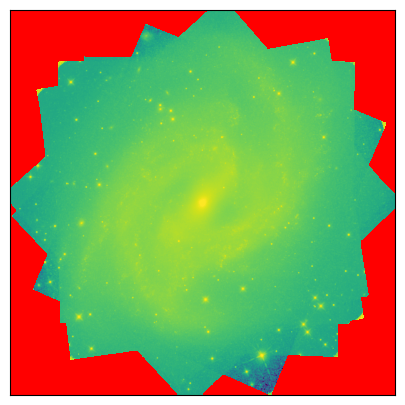

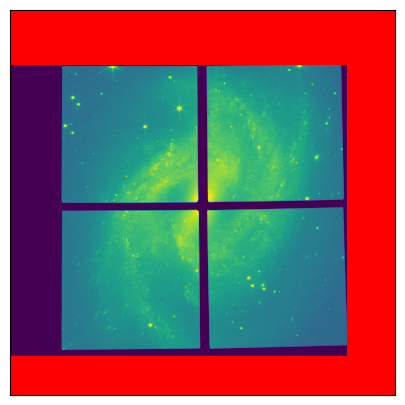

In [5]:
# cutout JWST images near the galaxy only: we don't need the halo part
cutouts_dict = {}
for filt,img in images_dict.items():
    cutouts_dict[filt] = Cutout2D(img.data,center_coord,cutout_size,img.wcs,mode='partial')

astroplot(cutouts_dict['F160W'].data)
astroplot(cutouts_dict['F090W'].data)

# rotate and reproject all images onto the same scale
wcs_list = [cutout.wcs for cutout in cutouts_dict.values()]
wcs_northup,shape_out = find_optimal_celestial_wcs(wcs_list,rotate=0,resolution=target_resolution)

# reproject
this uses a lot of memories. run one by one and restart the kernel to prevent crashing

In [6]:
for filtername in tqdm(images_dict.keys()):
    filt = images_dict[filtername]
    filt_cutout = cutouts_dict[filtername]
    
    
    # apply unit conversion if necessary
    if filtername in ['F090W','F150W','F277W']:
        # do nothing since JWST data is in MJy/sr already
        data_in_sb = filt_cutout.data
        
    elif filtername in ['F555W','F814W','F160W']:
        # HST images are in electrons/pix.
        # The unit need to be converted to surface brightness before reprojecting
        
        # determine original pixel area
        orig_pix_scale = filt.wcs.proj_plane_pixel_scales()[0].to(u.arcsec)
        orig_pix_area = (orig_pix_scale**2).to(u.sr)

        # use header calibration info to convert data to surface brightness
        PHOTFNU = filt.header['PHOTFNU'] * u.Jy * u.s / u.electron
        EXPTIME = filt.header['EXPTIME'] * u.s
        data = (filt_cutout.data * u.electron) / EXPTIME
        data_in_sb = (data * PHOTFNU / orig_pix_area).to(u.MJy/u.sr).value
    
    # reproject
    # note: setting conserve_flux=False is important when the input unit is surface brightness (e.g., Mjy/sr)
    array, footprint = reproject_adaptive((data_in_sb,filt_cutout.wcs), 
                                      output_projection = wcs_northup,
                                      shape_out=shape_out,
                                      conserve_flux=False)
    # astroplot(array)
    # plt.show()
    
    # save data
    output_file = output_folder+f'{filtername}.fits'

    # Save array as a FITS file
    fits.writeto(output_file, 
                data=array, 
                header=wcs_northup.to_header(),
                overwrite=True)

  0%|          | 0/6 [00:00<?, ?it/s]